In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os.path
import re
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64
import cv2


from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import seaborn as sns

import tensorflow as tf

# Keras imports
import keras
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.models import Sequential, Model
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Set pandas options
pd.set_option('display.max_columns', None)

In [3]:
# Borrowed from a kaggle post to display images inside a dataframe
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [4]:
# A function that counts the number of classes of images to train
def get_classes(path):
    """Returns the number of files and subdirectories in a directory. Intended
    to be used to count classes of images to use to train VGG19.
    Input: a filesystem path.
    Outpit: The number of files and subdirectories in a directory."""
    directories = glob(os.path.join(os.path.expanduser(path), '*'))
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('~/p5/data/interim/train'))
n_classes

50

In [5]:
# Create a model based on a topless VGG19 model. 
vgg19 = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [12]:
# Add a new top to the VGG19 model
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Show a summary of the model.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
# Set the paths of the train, validate, and test images.
train_path = os.path.expanduser('~/p5/data/interim/train')
test_path = os.path.expanduser('~/p5/data/interim/test')
valid_path = os.path.expanduser('~/p5/data/interim/valid')

In [15]:
# Create ImageDataGenerators to feed images to the model.
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 2766 images belonging to 50 classes.
Found 605 images belonging to 50 classes.
Found 543 images belonging to 50 classes.


In [16]:
# Compile the model
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model using early stopping, and checlpoints.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=500,
                    verbose=2, 
                    callbacks=[es, mc])

Epoch 1/500
 - 13s - loss: 3.2246 - acc: 0.5833 - val_loss: 3.7567 - val_acc: 0.5500

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to best_model.h5
Epoch 2/500
 - 13s - loss: 4.0928 - acc: 0.5417 - val_loss: 2.0575 - val_acc: 0.7000

Epoch 00002: val_acc improved from 0.55000 to 0.70000, saving model to best_model.h5
Epoch 3/500
 - 13s - loss: 3.6605 - acc: 0.6250 - val_loss: 5.2235 - val_acc: 0.5500

Epoch 00003: val_acc did not improve from 0.70000
Epoch 4/500
 - 13s - loss: 3.0725 - acc: 0.6250 - val_loss: 3.6553 - val_acc: 0.7000

Epoch 00004: val_acc did not improve from 0.70000
Epoch 5/500
 - 13s - loss: 4.2473 - acc: 0.5833 - val_loss: 4.2472 - val_acc: 0.6000

Epoch 00005: val_acc did not improve from 0.70000
Epoch 6/500
 - 13s - loss: 6.9413 - acc: 0.4167 - val_loss: 3.1625 - val_acc: 0.8000

Epoch 00006: val_acc improved from 0.70000 to 0.80000, saving model to best_model.h5
Epoch 7/500
 - 13s - loss: 2.3850 - acc: 0.7500 - val_loss: 2.6107 - val_acc: 0.80


Epoch 00059: val_acc did not improve from 0.90000
Epoch 60/500
 - 13s - loss: 4.4471 - acc: 0.6667 - val_loss: 3.8131 - val_acc: 0.6000

Epoch 00060: val_acc did not improve from 0.90000
Epoch 61/500
 - 13s - loss: 4.4150 - acc: 0.5833 - val_loss: 4.1621 - val_acc: 0.6000

Epoch 00061: val_acc did not improve from 0.90000
Epoch 62/500
 - 13s - loss: 3.3968 - acc: 0.7500 - val_loss: 2.3702 - val_acc: 0.7500

Epoch 00062: val_acc did not improve from 0.90000
Epoch 63/500
 - 13s - loss: 3.4026 - acc: 0.6250 - val_loss: 2.1063 - val_acc: 0.7000

Epoch 00063: val_acc did not improve from 0.90000
Epoch 64/500
 - 13s - loss: 2.1179 - acc: 0.7500 - val_loss: 2.2325 - val_acc: 0.7500

Epoch 00064: val_acc did not improve from 0.90000
Epoch 65/500
 - 13s - loss: 1.5480 - acc: 0.7500 - val_loss: 2.7394 - val_acc: 0.6500

Epoch 00065: val_acc did not improve from 0.90000
Epoch 66/500
 - 13s - loss: 1.9462 - acc: 0.7500 - val_loss: 5.4653 - val_acc: 0.5500

Epoch 00066: val_acc did not improve fro

In [20]:
model = load_model('best_model.h5')

In [ ]:
# Train the model using early stopping, and checlpoints.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=500,
                    verbose=2, 
                    callbacks=[es, mc])

In [21]:
for layer in model.layers:
    layer.trainable = True
for layer in model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [47]:
# Train the model using early stopping, and checlpoints.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=500,
                    verbose=2, 
                    callbacks=[es, mc])

Epoch 1/500
 - 20s - loss: 1.9491 - acc: 0.7917 - val_loss: 2.6916 - val_acc: 0.6500

Epoch 00001: val_loss improved from inf to 2.69157, saving model to best_model.h5
Epoch 2/500
 - 22s - loss: 1.0326 - acc: 0.8750 - val_loss: 0.1271 - val_acc: 0.9500

Epoch 00002: val_loss improved from 2.69157 to 0.12713, saving model to best_model.h5
Epoch 3/500
 - 22s - loss: 2.8749 - acc: 0.7500 - val_loss: 3.4098 - val_acc: 0.5500

Epoch 00003: val_loss did not improve from 0.12713
Epoch 4/500
 - 22s - loss: 1.4753 - acc: 0.8333 - val_loss: 3.1095 - val_acc: 0.7000

Epoch 00004: val_loss did not improve from 0.12713
Epoch 5/500
 - 21s - loss: 2.3646 - acc: 0.6667 - val_loss: 2.3819 - val_acc: 0.8000

Epoch 00005: val_loss did not improve from 0.12713
Epoch 6/500
 - 21s - loss: 2.5211 - acc: 0.7917 - val_loss: 2.2853 - val_acc: 0.7500

Epoch 00006: val_loss did not improve from 0.12713
Epoch 7/500
 - 21s - loss: 2.0357 - acc: 0.7083 - val_loss: 1.1164 - val_acc: 0.8500

Epoch 00007: val_loss did 

 - 21s - loss: 1.6047 - acc: 0.8333 - val_loss: 0.2959 - val_acc: 0.9000

Epoch 00060: val_loss did not improve from 0.12713
Epoch 61/500
 - 21s - loss: 0.9674 - acc: 0.8750 - val_loss: 2.4303 - val_acc: 0.7000

Epoch 00061: val_loss did not improve from 0.12713
Epoch 62/500
 - 21s - loss: 1.6924 - acc: 0.7917 - val_loss: 1.4407 - val_acc: 0.8000

Epoch 00062: val_loss did not improve from 0.12713
Epoch 63/500
 - 22s - loss: 1.4534 - acc: 0.8750 - val_loss: 1.5340 - val_acc: 0.8500

Epoch 00063: val_loss did not improve from 0.12713
Epoch 64/500
 - 21s - loss: 0.2167 - acc: 0.9167 - val_loss: 0.7611 - val_acc: 0.7500

Epoch 00064: val_loss did not improve from 0.12713
Epoch 65/500
 - 21s - loss: 1.6551 - acc: 0.7917 - val_loss: 0.9581 - val_acc: 0.8500

Epoch 00065: val_loss did not improve from 0.12713
Epoch 66/500
 - 22s - loss: 0.7625 - acc: 0.9167 - val_loss: 0.5056 - val_acc: 0.8000

Epoch 00066: val_loss did not improve from 0.12713
Epoch 67/500
 - 22s - loss: 2.2750 - acc: 0.750

 - 21s - loss: 1.4774 - acc: 0.7500 - val_loss: 1.3901 - val_acc: 0.7500

Epoch 00119: val_loss did not improve from 0.00749
Epoch 120/500
 - 21s - loss: 0.7458 - acc: 0.9167 - val_loss: 0.1086 - val_acc: 0.9500

Epoch 00120: val_loss did not improve from 0.00749
Epoch 121/500
 - 21s - loss: 0.3102 - acc: 0.9167 - val_loss: 1.8255 - val_acc: 0.8000

Epoch 00121: val_loss did not improve from 0.00749
Epoch 122/500
 - 21s - loss: 1.2500 - acc: 0.7083 - val_loss: 1.9687 - val_acc: 0.8000

Epoch 00122: val_loss did not improve from 0.00749
Epoch 123/500
 - 21s - loss: 1.7378 - acc: 0.8333 - val_loss: 1.6806 - val_acc: 0.7500

Epoch 00123: val_loss did not improve from 0.00749
Epoch 124/500
 - 21s - loss: 0.7345 - acc: 0.9167 - val_loss: 0.3788 - val_acc: 0.9500

Epoch 00124: val_loss did not improve from 0.00749
Epoch 125/500
 - 21s - loss: 0.2718 - acc: 0.9167 - val_loss: 0.9472 - val_acc: 0.8500

Epoch 00125: val_loss did not improve from 0.00749
Epoch 126/500
 - 22s - loss: 0.8815 - acc

 - 21s - loss: 0.1197 - acc: 0.9583 - val_loss: 1.0819 - val_acc: 0.8500

Epoch 00178: val_loss did not improve from 0.00749
Epoch 179/500
 - 21s - loss: 0.0508 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.9500

Epoch 00179: val_loss did not improve from 0.00749
Epoch 180/500
 - 22s - loss: 0.8649 - acc: 0.9167 - val_loss: 0.8938 - val_acc: 0.9000

Epoch 00180: val_loss did not improve from 0.00749
Epoch 181/500
 - 21s - loss: 0.7145 - acc: 0.9583 - val_loss: 0.0031 - val_acc: 1.0000

Epoch 00181: val_loss improved from 0.00749 to 0.00310, saving model to best_model.h5
Epoch 182/500
 - 21s - loss: 0.0076 - acc: 1.0000 - val_loss: 1.9399 - val_acc: 0.8500

Epoch 00182: val_loss did not improve from 0.00310
Epoch 183/500
 - 22s - loss: 0.0399 - acc: 1.0000 - val_loss: 1.1587 - val_acc: 0.7500

Epoch 00183: val_loss did not improve from 0.00310
Epoch 184/500
 - 22s - loss: 0.8722 - acc: 0.9167 - val_loss: 0.0684 - val_acc: 1.0000

Epoch 00184: val_loss did not improve from 0.00310
Epoch 


Epoch 00236: val_loss did not improve from 0.00050
Epoch 237/500
 - 21s - loss: 0.4860 - acc: 0.8333 - val_loss: 0.9451 - val_acc: 0.9000

Epoch 00237: val_loss did not improve from 0.00050
Epoch 238/500
 - 21s - loss: 0.8056 - acc: 0.9167 - val_loss: 1.0857 - val_acc: 0.8500

Epoch 00238: val_loss did not improve from 0.00050
Epoch 239/500
 - 21s - loss: 0.6410 - acc: 0.8333 - val_loss: 0.8103 - val_acc: 0.9000

Epoch 00239: val_loss did not improve from 0.00050
Epoch 240/500
 - 21s - loss: 0.5111 - acc: 0.9167 - val_loss: 0.8764 - val_acc: 0.9000

Epoch 00240: val_loss did not improve from 0.00050
Epoch 241/500
 - 21s - loss: 0.7832 - acc: 0.9167 - val_loss: 1.0732 - val_acc: 0.9000

Epoch 00241: val_loss did not improve from 0.00050
Epoch 242/500
 - 21s - loss: 0.8468 - acc: 0.9167 - val_loss: 0.1077 - val_acc: 0.9500

Epoch 00242: val_loss did not improve from 0.00050
Epoch 243/500
 - 21s - loss: 0.1219 - acc: 0.9583 - val_loss: 0.0499 - val_acc: 1.0000

Epoch 00243: val_loss did 

 - 21s - loss: 2.0423 - acc: 0.8750 - val_loss: 1.6121 - val_acc: 0.9000

Epoch 00295: val_loss did not improve from 0.00004
Epoch 296/500
 - 21s - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000

Epoch 00296: val_loss did not improve from 0.00004
Epoch 297/500
 - 21s - loss: 1.3543 - acc: 0.9167 - val_loss: 0.0083 - val_acc: 1.0000

Epoch 00297: val_loss did not improve from 0.00004
Epoch 298/500
 - 21s - loss: 0.1448 - acc: 0.9583 - val_loss: 0.8414 - val_acc: 0.9500

Epoch 00298: val_loss did not improve from 0.00004
Epoch 299/500
 - 22s - loss: 1.1049 - acc: 0.8750 - val_loss: 0.3159 - val_acc: 0.9500

Epoch 00299: val_loss did not improve from 0.00004
Epoch 300/500
 - 21s - loss: 0.7223 - acc: 0.9583 - val_loss: 2.4189 - val_acc: 0.8500

Epoch 00300: val_loss did not improve from 0.00004
Epoch 301/500
 - 21s - loss: 1.4011 - acc: 0.8750 - val_loss: 0.0060 - val_acc: 1.0000

Epoch 00301: val_loss did not improve from 0.00004
Epoch 302/500
 - 23s - loss: 0.0241 - acc

 - 22s - loss: 0.6872 - acc: 0.9583 - val_loss: 2.4214 - val_acc: 0.8500

Epoch 00354: val_loss did not improve from 0.00004
Epoch 355/500
 - 21s - loss: 0.0120 - acc: 1.0000 - val_loss: 0.8098 - val_acc: 0.9500

Epoch 00355: val_loss did not improve from 0.00004
Epoch 356/500
 - 21s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000

Epoch 00356: val_loss did not improve from 0.00004
Epoch 357/500
 - 21s - loss: 0.0337 - acc: 1.0000 - val_loss: 0.2580 - val_acc: 0.9000

Epoch 00357: val_loss did not improve from 0.00004
Epoch 358/500
 - 21s - loss: 0.6772 - acc: 0.9583 - val_loss: 0.4141 - val_acc: 0.9000

Epoch 00358: val_loss did not improve from 0.00004
Epoch 359/500
 - 22s - loss: 1.3507 - acc: 0.9167 - val_loss: 0.1051 - val_acc: 0.9500

Epoch 00359: val_loss did not improve from 0.00004
Epoch 360/500
 - 22s - loss: 2.0191 - acc: 0.8750 - val_loss: 0.8157 - val_acc: 0.9500

Epoch 00360: val_loss did not improve from 0.00004
Epoch 361/500
 - 21s - loss: 8.5731e-04 -

 - 22s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.3636 - val_acc: 0.9500

Epoch 00413: val_loss did not improve from 0.00004
Epoch 414/500
 - 21s - loss: 1.3435 - acc: 0.9167 - val_loss: 0.8193 - val_acc: 0.9500

Epoch 00414: val_loss did not improve from 0.00004
Epoch 415/500
 - 21s - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0894 - val_acc: 0.9500

Epoch 00415: val_loss did not improve from 0.00004
Epoch 416/500
 - 21s - loss: 1.4086 - acc: 0.8750 - val_loss: 0.0024 - val_acc: 1.0000

Epoch 00416: val_loss did not improve from 0.00004
Epoch 417/500
 - 22s - loss: 0.0057 - acc: 1.0000 - val_loss: 0.2098 - val_acc: 0.9500

Epoch 00417: val_loss did not improve from 0.00004
Epoch 418/500
 - 22s - loss: 1.3505e-04 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000

Epoch 00418: val_loss did not improve from 0.00004
Epoch 419/500
 - 21s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.9028 - val_acc: 0.9000

Epoch 00419: val_loss did not improve from 0.00004
Epoch 420/500
 - 21s - loss: 3.8290e-

 - 21s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.3194 - val_acc: 0.9500

Epoch 00472: val_loss did not improve from 0.00004
Epoch 473/500
 - 21s - loss: 0.6733 - acc: 0.9583 - val_loss: 3.1735e-04 - val_acc: 1.0000

Epoch 00473: val_loss did not improve from 0.00004
Epoch 474/500
 - 21s - loss: 0.7399 - acc: 0.9167 - val_loss: 0.9109 - val_acc: 0.9000

Epoch 00474: val_loss did not improve from 0.00004
Epoch 475/500
 - 21s - loss: 0.0020 - acc: 1.0000 - val_loss: 1.7793 - val_acc: 0.8500

Epoch 00475: val_loss did not improve from 0.00004
Epoch 476/500
 - 21s - loss: 0.1104 - acc: 0.9583 - val_loss: 1.0354 - val_acc: 0.8500

Epoch 00476: val_loss did not improve from 0.00004
Epoch 477/500
 - 23s - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9500

Epoch 00477: val_loss did not improve from 0.00004
Epoch 478/500
 - 21s - loss: 0.6731 - acc: 0.9583 - val_loss: 0.1926 - val_acc: 0.9500

Epoch 00478: val_loss did not improve from 0.00004
Epoch 479/500
 - 21s - loss: 0.6761 -

In [48]:
# model.save('hieroglyphs_vgg19_fully_trainable.h5')

In [ ]:
# model = load_model('hieroglyphs_vgg19.h5')

In [49]:
# model = load_model('best_model.h5')

In [50]:
# Run test batches through the model to see how it performs.
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_batches.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)

543/543 [==============================] - 175s 322ms/step


In [51]:
# Get an array of the top predictions
predicted_class_indices = np.argmax(pred,axis=1)

In [52]:
# Use class indices to get the predicted classes. Compare them to their actual class
# and create a dataframe from this imformation
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
pred_dict = {'predictions': predictions,
             'class_index': predicted_class_indices,
             'filename': test_batches.filenames}
df = pd.DataFrame(pred_dict)
df['glyph'] = df.apply(lambda row: re.match(r'^([A-Z]{1}\d+)/', row['filename']).group(1), axis=1)
df['match'] = df['predictions'] == df['glyph']
df['file_class_index'] = df.apply(lambda row: train_batches.class_indices[row['glyph']], axis=1)
df.head()

,predictions,class_index,filename,glyph,match,file_class_index
0,D2,0,D2/070242_D2.png,D2,True,0
1,D2,0,D2/220196_D2.png,D2,True,0
2,D21,1,D21/030269_D21.png,D21,True,1
3,D21,1,D21/030273_D21.png,D21,True,1
4,D21,1,D21/050286_D21.png,D21,True,1


In [53]:
# View some of the incorrect predictions
df[df['match'] == False].sample(10)

,predictions,class_index,filename,glyph,match,file_class_index
44,D21,1,D4/090367_D4.png,D4,False,5
263,V13,42,N1/200058_N1.png,N1,False,22
43,X1,48,D4/050064_D4.png,D4,False,5
240,S29,38,M17/230056_M17.png,M17,False,19
112,I10,17,G17/230481_G17.png,G17,False,11
264,V13,42,N1/230183_N1.png,N1,False,22
26,O1,30,D28/220113_D28.png,D28,False,2
70,V31,44,E34/090074_E34.png,E34,False,9
130,G17,11,G35/090391_G35.png,G35,False,13
66,D35,3,E34/070247_E34.png,E34,False,9


In [54]:
# Calculate the accuracy of the predictions
acc = df['match'].sum() / len(df)
acc

0.9539594843462247

In [55]:
# Print the F1, and recall scores along with the classification report.
print('F1 Score:' , f1_score(df['file_class_index'], df['class_index'], average='weighted'))
print('\nRecall Score:' , recall_score(df['file_class_index'], df['class_index'], average='weighted'))
print('\nClassification Report:\n' , classification_report(df['file_class_index'], df['class_index']))

F1 Score: 0.9459737602621977

Recall Score: 0.9539594843462247

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.88      1.00      0.94        22
           2       1.00      0.67      0.80         3
           3       0.80      1.00      0.89         8
           4       1.00      0.88      0.93         8
           5       0.00      0.00      0.00         6
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       1.00      0.83      0.91        18
          10       1.00      1.00      1.00         6
          11       0.94      0.97      0.95        32
          12       0.75      1.00      0.86         3
          13       1.00      0.88      0.93         8
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00    

/Applications/conda/anaconda3/envs/p5/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/conda/anaconda3/envs/p5/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


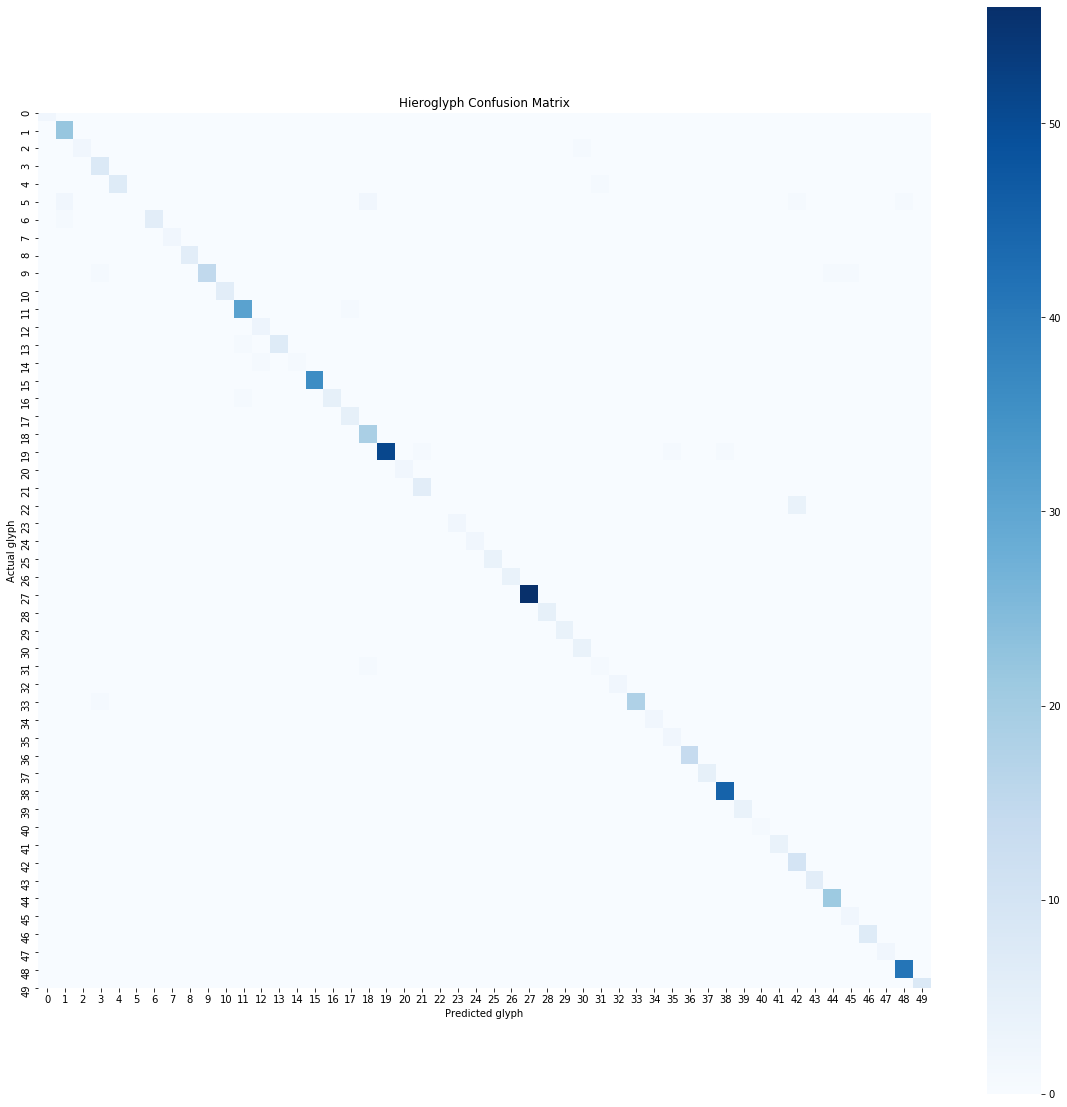

In [56]:
# Plot a confusion matrix for the hieroglyph classifications
glyph_confusion = confusion_matrix(df['file_class_index'], df['class_index'])
plt.figure(figsize=(20,20))
sns.heatmap(glyph_confusion, cmap=plt.cm.Blues, annot=False, square=True)#,

plt.xlabel('Predicted glyph')
plt.ylabel('Actual glyph')
plt.title('Hieroglyph Confusion Matrix');

In [57]:
m_classes =  len(get_classes('/Users/scott/p5/data/processed/modeling_all/train'))
m_classes

11

In [58]:
# Create a new model that will classify a smaller number of hieroglyphs, but of images contaminated
# with parts of surrounding glyphs.
base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = True
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(m_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model2 = Model(inputs=base_model.input, outputs=predictions)

In [59]:
# Print model2. summary
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [60]:
# SEt path for the second model
train_path2 = os.path.expanduser('/Users/scott/p5/data/processed/modeling_all/train/')
test_path2 = os.path.expanduser('/Users/scott/p5/data/processed/modeling_all/test/')
valid_path2 = os.path.expanduser('/Users/scott/p5/data/processed/modeling_all/valid/')

In [61]:
# Create ImageDataGenerators to feed images to the model.
train_batches2 = ImageDataGenerator().flow_from_directory(train_path2, 
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches2 = ImageDataGenerator().flow_from_directory(valid_path2, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches2 = ImageDataGenerator().flow_from_directory(test_path2, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)

Found 3612 images belonging to 11 classes.
Found 451 images belonging to 11 classes.
Found 456 images belonging to 11 classes.


In [62]:
# Compile the second model
model2.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
# Train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model2.fit_generator(train_batches2, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches2, 
                    validation_steps=4,
                    epochs=600,
                    verbose=2, 
                    callbacks=[es, mc])

Epoch 1/600
 - 24s - loss: 9.7485 - acc: 0.1250 - val_loss: 8.4336 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to best_model2.h5
Epoch 2/600
 - 21s - loss: 6.9285 - acc: 0.1250 - val_loss: 7.9446 - val_acc: 0.3000

Epoch 00002: val_acc improved from 0.10000 to 0.30000, saving model to best_model2.h5
Epoch 3/600
 - 21s - loss: 6.0522 - acc: 0.2500 - val_loss: 7.2082 - val_acc: 0.2000

Epoch 00003: val_acc did not improve from 0.30000
Epoch 4/600
 - 21s - loss: 5.7114 - acc: 0.3750 - val_loss: 6.9512 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.30000
Epoch 5/600
 - 21s - loss: 5.4773 - acc: 0.2500 - val_loss: 3.4537 - val_acc: 0.1500

Epoch 00005: val_acc did not improve from 0.30000
Epoch 6/600
 - 21s - loss: 5.3241 - acc: 0.0833 - val_loss: 3.1942 - val_acc: 0.2000

Epoch 00006: val_acc did not improve from 0.30000
Epoch 7/600
 - 21s - loss: 3.3699 - acc: 0.2917 - val_loss: 3.6383 - val_acc: 0.1000

Epoch 00007: val_acc did not 


Epoch 00058: val_acc did not improve from 0.80000
Epoch 59/600
 - 21s - loss: 1.2988 - acc: 0.5833 - val_loss: 1.3942 - val_acc: 0.5000

Epoch 00059: val_acc did not improve from 0.80000
Epoch 60/600
 - 21s - loss: 1.1520 - acc: 0.7083 - val_loss: 1.0350 - val_acc: 0.6500

Epoch 00060: val_acc did not improve from 0.80000
Epoch 61/600
 - 21s - loss: 1.2111 - acc: 0.6667 - val_loss: 0.9429 - val_acc: 0.7500

Epoch 00061: val_acc did not improve from 0.80000
Epoch 62/600
 - 21s - loss: 1.2582 - acc: 0.6250 - val_loss: 0.8673 - val_acc: 0.7500

Epoch 00062: val_acc did not improve from 0.80000
Epoch 63/600
 - 21s - loss: 1.1421 - acc: 0.6250 - val_loss: 1.1475 - val_acc: 0.8000

Epoch 00063: val_acc did not improve from 0.80000
Epoch 64/600
 - 21s - loss: 1.2953 - acc: 0.6250 - val_loss: 0.9986 - val_acc: 0.6500

Epoch 00064: val_acc did not improve from 0.80000
Epoch 65/600
 - 21s - loss: 0.9844 - acc: 0.7083 - val_loss: 1.6167 - val_acc: 0.5500

Epoch 00065: val_acc did not improve fro


Epoch 00117: val_acc did not improve from 0.95000
Epoch 118/600
 - 21s - loss: 0.9231 - acc: 0.7083 - val_loss: 0.9927 - val_acc: 0.7000

Epoch 00118: val_acc did not improve from 0.95000
Epoch 119/600
 - 21s - loss: 0.8101 - acc: 0.7083 - val_loss: 0.7853 - val_acc: 0.8000

Epoch 00119: val_acc did not improve from 0.95000
Epoch 120/600
 - 21s - loss: 1.0164 - acc: 0.7083 - val_loss: 1.0954 - val_acc: 0.6500

Epoch 00120: val_acc did not improve from 0.95000
Epoch 121/600
 - 21s - loss: 0.8125 - acc: 0.6250 - val_loss: 0.5995 - val_acc: 0.8500

Epoch 00121: val_acc did not improve from 0.95000
Epoch 122/600
 - 21s - loss: 0.8683 - acc: 0.7917 - val_loss: 0.7727 - val_acc: 0.7500

Epoch 00122: val_acc did not improve from 0.95000
Epoch 123/600
 - 21s - loss: 0.5680 - acc: 0.7917 - val_loss: 0.4062 - val_acc: 0.8500

Epoch 00123: val_acc did not improve from 0.95000
Epoch 124/600
 - 21s - loss: 0.4605 - acc: 0.8333 - val_loss: 1.0692 - val_acc: 0.7500

Epoch 00124: val_acc did not impr

 - 21s - loss: 0.2163 - acc: 0.8750 - val_loss: 0.1911 - val_acc: 0.9500

Epoch 00177: val_acc did not improve from 1.00000
Epoch 178/600
 - 21s - loss: 0.2599 - acc: 0.9167 - val_loss: 0.5093 - val_acc: 0.9000

Epoch 00178: val_acc did not improve from 1.00000
Epoch 179/600
 - 21s - loss: 0.3503 - acc: 0.8750 - val_loss: 0.2507 - val_acc: 0.9500

Epoch 00179: val_acc did not improve from 1.00000
Epoch 180/600
 - 21s - loss: 0.5859 - acc: 0.9167 - val_loss: 0.5317 - val_acc: 0.8500

Epoch 00180: val_acc did not improve from 1.00000
Epoch 181/600
 - 21s - loss: 0.3255 - acc: 0.9167 - val_loss: 0.2522 - val_acc: 0.9000

Epoch 00181: val_acc did not improve from 1.00000
Epoch 182/600
 - 20s - loss: 0.3018 - acc: 0.9167 - val_loss: 0.4883 - val_acc: 0.8750

Epoch 00182: val_acc did not improve from 1.00000
Epoch 183/600
 - 21s - loss: 0.3826 - acc: 0.9167 - val_loss: 0.1438 - val_acc: 1.0000

Epoch 00183: val_acc did not improve from 1.00000
Epoch 184/600
 - 21s - loss: 0.4986 - acc: 0.833


Epoch 00236: val_acc did not improve from 1.00000
Epoch 237/600
 - 21s - loss: 0.1336 - acc: 0.9583 - val_loss: 0.0365 - val_acc: 1.0000

Epoch 00237: val_acc did not improve from 1.00000
Epoch 238/600
 - 21s - loss: 0.2786 - acc: 0.9167 - val_loss: 0.0924 - val_acc: 1.0000

Epoch 00238: val_acc did not improve from 1.00000
Epoch 239/600
 - 21s - loss: 0.0926 - acc: 1.0000 - val_loss: 0.2794 - val_acc: 0.9000

Epoch 00239: val_acc did not improve from 1.00000
Epoch 240/600
 - 21s - loss: 0.2492 - acc: 0.9583 - val_loss: 0.4323 - val_acc: 0.9000

Epoch 00240: val_acc did not improve from 1.00000
Epoch 241/600
 - 23s - loss: 0.2377 - acc: 0.9167 - val_loss: 0.2486 - val_acc: 0.9000

Epoch 00241: val_acc did not improve from 1.00000
Epoch 242/600
 - 21s - loss: 0.2327 - acc: 0.9583 - val_loss: 0.3274 - val_acc: 0.9000

Epoch 00242: val_acc did not improve from 1.00000
Epoch 243/600
 - 21s - loss: 0.2968 - acc: 0.9167 - val_loss: 0.1932 - val_acc: 0.9500

Epoch 00243: val_acc did not impr

 - 20s - loss: 0.2933 - acc: 0.9167 - val_loss: 1.7348 - val_acc: 0.6250

Epoch 00296: val_acc did not improve from 1.00000
Epoch 297/600
 - 21s - loss: 0.4987 - acc: 0.7917 - val_loss: 0.3349 - val_acc: 0.8500

Epoch 00297: val_acc did not improve from 1.00000
Epoch 298/600
 - 21s - loss: 0.1037 - acc: 1.0000 - val_loss: 0.3880 - val_acc: 0.9000

Epoch 00298: val_acc did not improve from 1.00000
Epoch 299/600
 - 21s - loss: 0.2195 - acc: 0.9167 - val_loss: 0.2412 - val_acc: 0.9000

Epoch 00299: val_acc did not improve from 1.00000
Epoch 300/600
 - 21s - loss: 0.1174 - acc: 0.9583 - val_loss: 0.0099 - val_acc: 1.0000

Epoch 00300: val_acc did not improve from 1.00000
Epoch 301/600
 - 21s - loss: 0.1112 - acc: 0.9583 - val_loss: 0.1409 - val_acc: 0.9500

Epoch 00301: val_acc did not improve from 1.00000
Epoch 302/600
 - 21s - loss: 0.0410 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 1.0000

Epoch 00302: val_acc did not improve from 1.00000
Epoch 303/600
 - 21s - loss: 0.0696 - acc: 1.000


Epoch 00355: val_acc did not improve from 1.00000
Epoch 356/600
 - 21s - loss: 0.1078 - acc: 0.9583 - val_loss: 0.2261 - val_acc: 0.9000

Epoch 00356: val_acc did not improve from 1.00000
Epoch 357/600
 - 21s - loss: 0.1536 - acc: 0.9167 - val_loss: 0.0555 - val_acc: 1.0000

Epoch 00357: val_acc did not improve from 1.00000
Epoch 358/600
 - 21s - loss: 0.0439 - acc: 0.9583 - val_loss: 0.4008 - val_acc: 0.9500

Epoch 00358: val_acc did not improve from 1.00000
Epoch 359/600
 - 21s - loss: 0.1442 - acc: 0.9583 - val_loss: 0.4970 - val_acc: 0.9500

Epoch 00359: val_acc did not improve from 1.00000
Epoch 360/600
 - 21s - loss: 0.3879 - acc: 0.9167 - val_loss: 0.5500 - val_acc: 0.8500

Epoch 00360: val_acc did not improve from 1.00000
Epoch 361/600
 - 21s - loss: 0.0182 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 1.0000

Epoch 00361: val_acc did not improve from 1.00000
Epoch 362/600
 - 21s - loss: 0.0383 - acc: 1.0000 - val_loss: 0.5088 - val_acc: 0.9000

Epoch 00362: val_acc did not impr

 - 21s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.4502 - val_acc: 0.8500

Epoch 00415: val_acc did not improve from 1.00000
Epoch 416/600
 - 21s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1443 - val_acc: 0.9500

Epoch 00416: val_acc did not improve from 1.00000
Epoch 417/600
 - 21s - loss: 0.0497 - acc: 0.9583 - val_loss: 1.0948 - val_acc: 0.7500

Epoch 00417: val_acc did not improve from 1.00000
Epoch 418/600
 - 21s - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0835 - val_acc: 1.0000

Epoch 00418: val_acc did not improve from 1.00000
Epoch 419/600
 - 21s - loss: 0.0347 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 1.0000

Epoch 00419: val_acc did not improve from 1.00000
Epoch 420/600
 - 21s - loss: 0.2946 - acc: 0.9583 - val_loss: 0.0232 - val_acc: 1.0000

Epoch 00420: val_acc did not improve from 1.00000
Epoch 421/600
 - 21s - loss: 0.0603 - acc: 1.0000 - val_loss: 0.2955 - val_acc: 0.9000

Epoch 00421: val_acc did not improve from 1.00000
Epoch 422/600
 - 21s - loss: 0.3817 - acc: 0.958

In [ ]:
# Save the model
# model2.save('hieroglyphs_vgg19_custom_images_multiclass.h5')

In [ ]:
# Load the model from a saved file
# model2 = load_model('hieroglyphs_vgg19_N35_only_custom_images_multiclass.h5')
# model2 = load_model('hieroglyphs_vgg19_N35_only_custom_images_multiclass.h5')

In [64]:
# Run the test batches to test model performance
STEP_SIZE_TEST=test_batches2.n//test_batches2.batch_size
test_batches2.reset()
pred = model2.predict_generator(test_batches2,
steps = STEP_SIZE_TEST,
verbose=1)

456/456 [==============================] - 149s 327ms/step


In [65]:
# Get predictions
predicted_class_indices=np.argmax(pred,axis=1)

In [66]:
# Get the labels for the predictions
labels = (train_batches2.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in predicted_class_indices]

{'N35': 0, 'basket': 1, 'bird': 2, 'cloth': 3, 'cobra': 4, 'mouth': 5, 'reed': 6, 'sun': 7, 'tether': 8, 'viper': 9, 'wick': 10}
{0: 'N35', 1: 'basket', 2: 'bird', 3: 'cloth', 4: 'cobra', 5: 'mouth', 6: 'reed', 7: 'sun', 8: 'tether', 9: 'viper', 10: 'wick'}


In [67]:
def get_glyph_name(series):
    """Returns the name of the for each element of the input series."""
    file = series['filename']
    m = re.match(r'^([a-z]+)/', file)
    n = re.match(r'^([A-Z]{1}\d+)/', file)
    if m:
        return m.group(1)
    elif n:
        return n.group(1)
    else:
        return 'unknown'

In [68]:
# Create a dataframe fromthe predictions
pred_df = pd.DataFrame(predictions, columns=['predicted'])
pred_df = pred_df.merge(pd.DataFrame(test_batches2.filenames, columns=['filename']), left_index=True, right_index=True)
pred_df['glyph'] = pred_df.apply(lambda row: get_glyph_name(row), axis=1)
pred_df['match'] = pred_df['predicted'] == pred_df['glyph']
pred_df.head()

,predicted,filename,glyph,match
0,basket,N35/img_x_101_y_264.png,N35,False
1,N35,N35/img_x_106_y_15.png,N35,True
2,N35,N35/img_x_113_y_127.png,N35,True
3,N35,N35/img_x_121_y_102.png,N35,True
4,N35,N35/img_x_127_y_205.png,N35,True


In [69]:
# Get accuracy
acc = pred_df['match'].sum() / len(pred_df)
acc

0.9407894736842105

In [70]:
def get_indices(series, idx_dict):
    """Returns a numpy array from indices for input series of class names."""
    indices = pd.Series(index=series.index)
    for idx, val in series.iteritems():
        indices[idx] = idx_dict[val]
    return indices

In [71]:
# Set y_true, and y_pred for f1_score, recall, and confusion matrixes
y_pred = get_indices(pred_df.predicted, train_batches2.class_indices)
y_true = get_indices(pred_df.glyph, train_batches2.class_indices)
f1_score(y_true, y_pred, average='weighted')

0.9407882000923848

In [72]:
# Print the F1, and recall scores along with the classification report.
print('F1 Score:' , f1_score(y_true, y_pred, average='weighted'))
print('\nRecall Score:' , recall_score(y_true, y_pred, average='weighted'))
print('\nClassification Report:\n' , classification_report(y_true, y_pred))

F1 Score: 0.9407882000923848

Recall Score: 0.9407894736842105

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       118
         1.0       0.97      0.85      0.90        33
         2.0       1.00      1.00      1.00        44
         3.0       0.97      0.91      0.94        33
         4.0       0.94      0.84      0.89        19
         5.0       0.81      0.98      0.89        49
         6.0       0.93      0.95      0.94        58
         7.0       0.90      1.00      0.95        37
         8.0       1.00      0.89      0.94        18
         9.0       0.89      0.80      0.84        30
        10.0       1.00      0.94      0.97        17

    accuracy                           0.94       456
   macro avg       0.94      0.92      0.93       456
weighted avg       0.94      0.94      0.94       456



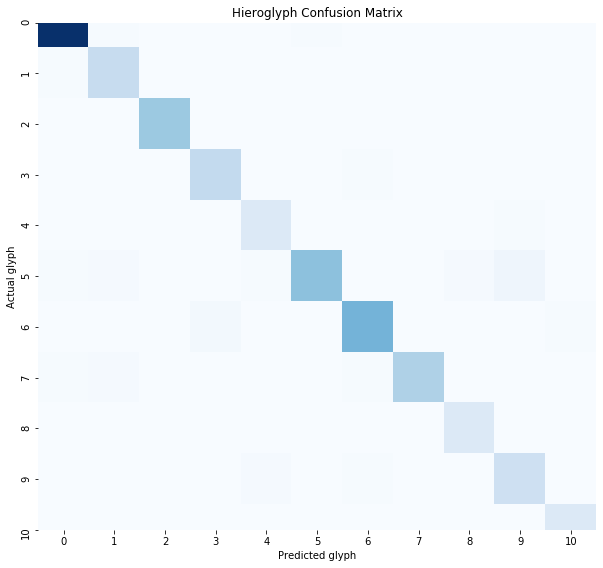

In [73]:
# Plot a confusion matrix for the hieroglyph classifications
glyph_confusion = confusion_matrix(y_pred, y_true)
plt.figure(figsize=(10,10))
sns.heatmap(glyph_confusion, cmap='Blues', annot=False, square=True, cbar=False)#,
plt.cbar = False

plt.xlabel('Predicted glyph')
plt.ylabel('Actual glyph')
plt.title('Hieroglyph Confusion Matrix');

In [74]:
# Create a thumbnail dataframe
tdf = pred_df.copy()
tdf.head()

,predicted,filename,glyph,match
0,basket,N35/img_x_101_y_264.png,N35,False
1,N35,N35/img_x_106_y_15.png,N35,True
2,N35,N35/img_x_113_y_127.png,N35,True
3,N35,N35/img_x_121_y_102.png,N35,True
4,N35,N35/img_x_127_y_205.png,N35,True


In [75]:
# Setup the thumbnail columns
tdf['pred_img'] = tdf.apply(lambda row: get_thumbnail(os.path.join('/Users/scott/p5/data/processed/modeling_all/test', row['filename'])), axis=1)

,predicted,filename,glyph,match,pred_img
0,basket,N35/img_x_101_y_264.png,N35,False,
33,sun,N35/img_x_281_y_13.png,N35,False,
51,mouth,N35/img_x_366_y_189.png,N35,False,
118,N35,basket/img_x_108_y_453.png,basket,False,
120,mouth,basket/img_x_128_y_446.png,basket,False,
122,mouth,basket/img_x_147_y_124.png,basket,False,
139,sun,basket/img_x_627_y_9.png,basket,False,
150,sun,basket/img_x_93_y_190.png,basket,False,
199,reed,cloth/img_x_141_y_198.png,cloth,False,
200,reed,cloth/img_x_224_y_93.png,cloth,False,

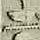
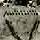
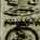
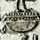
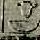
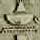
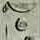
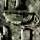
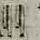
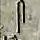
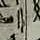
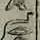
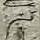
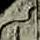
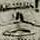
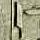
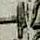
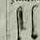
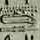
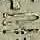
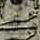
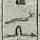
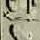
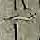
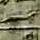
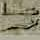
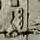

In [76]:
# Show some sample mismatches
HTML(tdf[tdf['match'] == False].to_html(formatters={'pred_img': image_formatter}, escape=False))

,predicted,filename,glyph,match,pred_img
261,N35,mouth/img_x_269_y_536.png,mouth,False,

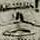

In [78]:
# Show some sample mismatches
HTML(tdf[(tdf['match'] == False) &  (tdf['glyph'] == 'mouth')].to_html(formatters={'pred_img': image_formatter}, escape=False))

In [79]:
from collections import defaultdict
mouths = defaultdict(int)
for idx, row in tdf[(tdf['match'] == False) &  (tdf['glyph'] == 'mouth')].iterrows():
    mouths[row['predicted']] += 1
for key, value in mouths.items():
    print(key, value)

N35 1


,predicted,filename,glyph,match,pred_img
261,N35,mouth/img_x_269_y_536.png,mouth,False,

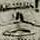

In [80]:
# Show some sample mismatches
HTML(tdf[(tdf['match'] == False) &  (tdf['glyph'] == 'mouth') & (tdf['predicted'] == 'N35')].to_html(formatters={'pred_img': image_formatter}, escape=False))

,predicted,filename,glyph,match,pred_img
401,mouth,tether/img_x_442_y_356.png,tether,False,
404,mouth,tether/img_x_56_y_119.png,tether,False,

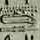
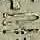

In [81]:
# Show some sample mismatches
HTML(tdf[(tdf['match'] == False) &  (tdf['glyph'] == 'tether')].to_html(formatters={'pred_img': image_formatter}, escape=False))

In [82]:
for layer in model2.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [83]:
model2.save('fully_trained_11_class.h5')

In [ ]:
def get_heat_value(img_segment, mdl, labels):
    resized_image = cv2.resize(img_segment, (224, 224))
    pred_array = mdl.predict(np.expand_dims(resized_image, axis=0))
    return pred_array

In [ ]:
# Orig Image Shape (1507, 1720, 3)
# img = cv2.imread('/home/scott/sync/Antewest.jpg')[250:1000, 1220:]
img = cv2.imread('/Users/scott/sync/Sync/hieroglyphs/Texts/Test_Image/Antewest.jpg')[250:400, 1220:1570]
print(img.shape)
plt.figure(figsize=(12,12))
plt.imshow(img)

In [ ]:
heat_map = []
window_height = 40
window_width = 40
for y_step in range(0, img.shape[0], 5):
    for x_step in range(0, img.shape[1], 5):
        print((x_step, y_step))
        # Get window_width x window_height image segement
        crop_img = img[y_step:y_step+window_height, x_step:x_step+window_width].copy()
        # Get the heat value of the image segemnt
        heat = get_heat_value(crop_img, model2, labels)
        # Appened heat value to heat map
        print(heat)
        heat_map.append(heat)

In [ ]:
model2.save('notop_base.h5')

In [ ]:
notop = load_model('notop_base.h5')

In [ ]:
notop.summary()

In [ ]:
notop.layers.pop()

In [ ]:
notop.summary()

In [ ]:
crop_img = img[:40, :40].copy()

In [ ]:
plt.imshow(crop_img)

In [ ]:
resized_image = cv2.resize(crop_img, (224, 224))
pred_array = notop.predict(np.expand_dims(resized_image, axis=0))

In [ ]:
pred_array

In [ ]:
# outputs=notop.get_layer('flatten_1').output
last_layer = Model(inputs=notop.input, outputs=notop.get_layer('flatten_1').output)
res = last_layer.predict(np.expand_dims(resized_image, axis=0))

In [ ]:
sum(res[0] == 0)